In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import re
import nltk
nltk.download(['stopwords', 'punkt', 'wordnet', 'omw-1.4'])
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Robbie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Robbie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Robbie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Robbie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# df = pd.read_csv('train.csv')
df=pd.read_csv('train.tsv', sep='\t')
df.head()

,label,text
0,0,Says the Annies List political group supports ...
1,1,When did the decline of coal start? It started...
2,2,"Hillary Clinton agrees with John McCain ""by vo..."
3,0,Health care reform legislation is likely to ma...
4,1,The economic turnaround started at the end of ...


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import EarlyStopping

In [4]:
x_train, x_test, y_train, y_test = train_test_split(df['text'],df['label'], test_size=0.2,random_state=42)


In [5]:
maxlen = 128
truncating = 'post'
padding = 'post'
oov_tok = '<00V>'
vocab_size = 1000

tokenizer = Tokenizer(num_words = vocab_size, char_level = False, oov_token = oov_tok)
tokenizer.fit_on_texts(x_train.astype("str"))

In [6]:
training_sequences = tokenizer.texts_to_sequences(x_train.astype("str"))
training_sequences = pad_sequences(training_sequences,
                                   maxlen = maxlen,
                                   padding = padding,
                                   truncating = truncating)

testing_sequences = tokenizer.texts_to_sequences(x_test.astype("str"))
testing_sequences = pad_sequences(testing_sequences,
                                  maxlen = maxlen,
                                  padding = padding,
                                  truncating = truncating)

In [7]:
import keras
from keras import layers

In [8]:
embedding_dim = 32
model = keras.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences = False)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3))
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam', metrics=['accuracy'])

In [9]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)
history = model.fit(training_sequences,
                    y_train,
                    epochs = 30,
                    validation_data = (testing_sequences, y_test),
                    callbacks = [],
                    verbose = 2)

Epoch 1/30
256/256 - 12s - loss: 1.0786 - accuracy: 0.3961 - val_loss: 1.0635 - val_accuracy: 0.4258 - 12s/epoch - 47ms/step
Epoch 2/30
256/256 - 7s - loss: 1.0405 - accuracy: 0.4532 - val_loss: 1.0578 - val_accuracy: 0.4434 - 7s/epoch - 27ms/step
Epoch 3/30
256/256 - 7s - loss: 1.0046 - accuracy: 0.4891 - val_loss: 1.0719 - val_accuracy: 0.4165 - 7s/epoch - 29ms/step
Epoch 4/30
256/256 - 7s - loss: 0.9778 - accuracy: 0.5066 - val_loss: 1.0950 - val_accuracy: 0.4214 - 7s/epoch - 27ms/step
Epoch 5/30
256/256 - 6s - loss: 0.9533 - accuracy: 0.5331 - val_loss: 1.1131 - val_accuracy: 0.4067 - 6s/epoch - 24ms/step
Epoch 6/30
256/256 - 6s - loss: 0.9228 - accuracy: 0.5515 - val_loss: 1.1328 - val_accuracy: 0.4033 - 6s/epoch - 25ms/step
Epoch 7/30
256/256 - 6s - loss: 0.8937 - accuracy: 0.5725 - val_loss: 1.1486 - val_accuracy: 0.4131 - 6s/epoch - 25ms/step
Epoch 8/30
256/256 - 6s - loss: 0.8658 - accuracy: 0.5963 - val_loss: 1.1628 - val_accuracy: 0.3921 - 6s/epoch - 25ms/step
Epoch 9/30
256

In [10]:
model.save("./sentinel.keras")

In [13]:
test_news = ["Says Donald Trump has bankrupted his companies not once, not twice but four times."]
test_news_seq = tokenizer.texts_to_sequences(test_news)
test_news_seq = pad_sequences(test_news_seq, maxlen = maxlen, padding = padding, truncating = truncating)

test_news_pred = model.predict(test_news_seq)
print(np.argmax(test_news_pred[0]))

1/1 [==============================] - 0s 21ms/step
2


In [16]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [18]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from keras import backend as K
K._get_available_gpus()

Num GPUs Available:  1


['/device:GPU:0']

In [19]:
test_y = []
x_test_small = x_test
y_test_small = y_test

i = 0
for test_news in x_test_small.astype("str"):
    test_news_seq = tokenizer.texts_to_sequences([test_news])
    test_news_seq = pad_sequences(test_news_seq, maxlen = maxlen, padding = padding, truncating = truncating)
    test_news_pred = model.predict(test_news_seq)
    test_y.append(test_news_pred[0])
    print(i)
    i  += 1


1/1 [==============================] - 0s 21ms/step
0
1/1 [==============================] - 0s 22ms/step
1
1/1 [==============================] - 0s 24ms/step
2
1/1 [==============================] - 0s 19ms/step
3
1/1 [==============================] - 0s 22ms/step
4
1/1 [==============================] - 0s 21ms/step
5
1/1 [==============================] - 0s 20ms/step
6
1/1 [==============================] - 0s 22ms/step
7
1/1 [==============================] - 0s 28ms/step
8
1/1 [==============================] - 0s 31ms/step
9
1/1 [==============================] - 0s 22ms/step
10
1/1 [==============================] - 0s 25ms/step
11
1/1 [==============================] - 0s 22ms/step
12
1/1 [==============================] - 0s 21ms/step
13
1/1 [==============================] - 0s 23ms/step
14
1/1 [==============================] - 0s 32ms/step
15
1/1 [==============================] - 0s 23ms/step
16
1/1 [==============================] - 0s 23ms/step
17
1/1 [===============

Accuracy:  0.39453125
Confusion matrix, without normalization


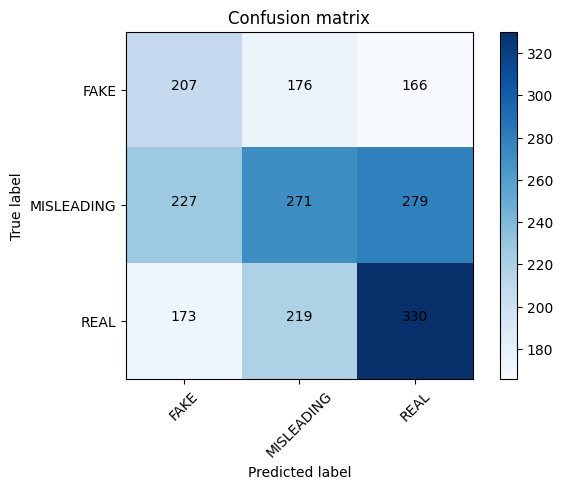

In [20]:
import itertools

test_y_int = []

for y in test_y:
    test_y_int.append(np.argmax(y))

cm = metrics.confusion_matrix(y_test, test_y_int)
score = metrics.accuracy_score(y_test, test_y_int)
print("Accuracy: ", score)
plot_confusion_matrix(cm, classes=['FAKE', 'MISLEADING', 'REAL'])